In [2]:
import sys

In [3]:
sys.executable

'/Users/alfonzo/Library/Application Support/pipx/venvs/jupyterlab/bin/python'

In [19]:
!'/Users/alfonzo/Library/Application Support/pipx/venvs/jupyterlab/bin/python' -m pip install elasticsearch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 654.0/654.0 kB 5.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 2.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: /Users/alfonzo/Library/Application Support/pipx/venvs/jupyterlab/bin/python -m pip install --upgrade pip


# Airflow DAG code 

In [1]:
from airflow import DAG
from airflow.operators.python import PythonOperator
from datetime import datetime, timedelta
import requests
import pdfplumber
import pytesseract
from PIL import Image
from bs4 import BeautifulSoup
import json
import re
from langchain.llms import HuggingFaceHub
from pydantic import BaseModel
import psycopg2
from elasticsearch import Elasticsearch

# Default arguments for the DAG
default_args = {
    "owner": "airflow",
    "depends_on_past": False,
    "start_date": datetime(2024, 2, 12),
    "retries": 1,
    "retry_delay": timedelta(minutes=5),
}

dag = DAG(
    "non_compliance_etl",
    default_args=default_args,
    description="ETL pipeline for non-compliance reports",
    schedule_interval=timedelta(days=1),
)

# Data extraction functions
def fetch_data_from_api():
    url = "https://api.fda.gov/warning-letters"  # Example API endpoint
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    return []

def scrape_web_page(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        return soup.get_text(" ", strip=True)
    return ""

def extract_text_from_pdf(file_path):
    text = ""
    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() + "\n"
    return text.strip()

def extract_text_from_image(file_path):
    image = Image.open(file_path)
    return pytesseract.image_to_string(image)

# Data transformation functions
class WarningLetterData(BaseModel):
    supplier_id: str
    record_date: str
    severity_level: str
    category_of_violation: str
    root_cause_category: str
    corrective_actions_suggested: list
    affected_product: str
    process_involved: str
    tone_of_letter: str
    length_of_letter: str
    deadline_for_resolution: str
    resolution_status: str
    follow_up_actions: list

def extract_json_from_response(response_text):
    json_pattern = r"\{.*\}"
    match = re.search(json_pattern, response_text, re.DOTALL)
    return match.group(0) if match else None

def structure_data(text):
    llm = HuggingFaceHub(repo_id="tiiuae/falcon-7b-instruct", model_kwargs={"temperature": 0.7})
    prompt = (
        "Extract the following structured JSON from the text: "
        "['supplier_id', 'record_date', 'severity_level', 'category_of_violation', 'root_cause_category', "
        "'corrective_actions_suggested', 'affected_product', 'process_involved', 'tone_of_letter', "
        "'length_of_letter', 'deadline_for_resolution', 'resolution_status', 'follow_up_actions']. "
        "Text: " + text
    )
    response = llm(prompt)
    json_data = extract_json_from_response(response)
    if json_data:
        try:
            parsed_data = json.loads(json_data)
            return WarningLetterData(**parsed_data).dict()
        except (json.JSONDecodeError, ValueError) as e:
            return {"error": f"Failed to parse extracted JSON: {str(e)}"}
    else:
        return {"error": "No valid JSON found"}

# Data loading functions
def load_to_postgres(data):
    conn = psycopg2.connect(dbname="compliance_db", user="user", password="pass", host="localhost")
    cursor = conn.cursor()
    cursor.execute("""
        INSERT INTO warning_letters (supplier_id, record_date, severity_level, category_of_violation, root_cause_category,
        corrective_actions_suggested, affected_product, process_involved, tone_of_letter, length_of_letter,
        deadline_for_resolution, resolution_status, follow_up_actions)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """, tuple(data.values()))
    conn.commit()
    cursor.close()
    conn.close()

def load_to_elasticsearch(data):
    es = Elasticsearch([{"host": "localhost", "port": 9200}])
    es.index(index="warning_letters", body=data)

def extract_transform_load():
    api_data = fetch_data_from_api()
    scraped_data = scrape_web_page("https://www.fda.gov/warning-letters")
    
    combined_text = "\n".join([scraped_data] + [entry['text'] for entry in api_data if 'text' in entry])
    structured_data = structure_data(combined_text)
    
    if "error" not in structured_data:
        load_to_postgres(structured_data)
        load_to_elasticsearch(structured_data)

task_etl = PythonOperator(
    task_id="extract_transform_load",
    python_callable=extract_transform_load,
    dag=dag,
)

task_etl


/var/folders/my/vcxzmhpd1l1f6bhyh61p0qqh0000gn/T/ipykernel_53277/2505346129.py:25 RemovedInAirflow3Warning: Param `schedule_interval` is deprecated and will be removed in a future release. Please use `schedule` instead.

<Task(PythonOperator): extract_transform_load>

# Render DAG

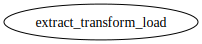

In [2]:
from airflow.utils.dag_cycle_tester import check_cycle
from airflow.models import DAG
import graphviz

def render_dag_graph(dag):
    check_cycle(dag)  # Ensure DAG has no cycles
    dot = graphviz.Digraph(format='png')

    for task in dag.tasks:
        dot.node(task.task_id)
        for downstream_task in task.downstream_list:
            dot.edge(task.task_id, downstream_task.task_id)

    dot.render("dag_visualization")  # Saves as dag_visualization.png
    return dot

# Render and save DAG visualization
render_dag_graph(dag)


# Render ETL graph

In [3]:
from graphviz import Digraph

dot = Digraph(format="png")

# Define ETL steps
dot.node("Extract", "Extract Data\n(API & Web Scraping)", shape="box", style="filled", fillcolor="lightblue")
dot.node("Transform", "Transform Data\n(NLP & Standardization)", shape="box", style="filled", fillcolor="lightgreen")
dot.node("Load_Postgres", "Load to PostgreSQL", shape="box", style="filled", fillcolor="lightyellow")
dot.node("Load_Elasticsearch", "Load to Elasticsearch", shape="box", style="filled", fillcolor="lightyellow")

# Define connections
dot.edge("Extract", "Transform")
dot.edge("Transform", "Load_Postgres")
dot.edge("Transform", "Load_Elasticsearch")

# Save as PNG
dot.render("dag_visualization")

print("DAG visualization saved as dag_visualization.png")


DAG visualization saved as dag_visualization.png
